In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare, kruskal, kstest, \
    lognorm, gamma, weibull_min, probplot, f_oneway, linregress, norm, spearmanr, ttest_1samp, wilcoxon 
import seaborn as sns
import os
import ast
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import itertools

In [2]:
input_dir = "Peakfinder Results" 

output_dir = "Analyzer Results"

In [3]:
import os
import pandas as pd
import numpy as np
import ast

dfs = {}


files = [file for file in os.listdir(input_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('OVERVIEW')]

for file in files:
    file_path = os.path.join(input_dir, file)
    dfs[file.split('.')[0]] = pd.read_excel(file_path)

framenames = list(dfs.keys())
results = framenames[0]
results_mtt = framenames[1]
results_tt = framenames[2]

print(f"Found {framenames} in {input_dir}.")

framenames.append('RESULTS_MERGED')
framenames.append('RESULTS_MERGED_MTT')
framenames.append('RESULTS_MERGED_TT')

experiments = dfs[results]['experiment'].unique().tolist()
variables = dfs[results].columns[4:].tolist()
parameters = dfs[results].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))



def average_list_columns(df):
    import numpy as np
    import ast

    def safe_mean(x):
        # If x is a string representing a list, convert to list
        if isinstance(x, str) and x.startswith('['):
            try:
                x = ast.literal_eval(x)
            except Exception:
                return np.nan
        # If x is a list, filter out None and np.nan
        if isinstance(x, list):
            x = [v for v in x if v is not None and not (isinstance(v, float) and np.isnan(v))]
            return np.mean(x) if len(x) > 0 else np.nan
        # If x is None or nan, return nan
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return np.nan
        # Otherwise, return x
        return x

    df_copy = df.copy()
    for col in df_copy.columns:
        if df_copy[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and x.startswith('['))).any():
            df_copy[col] = df_copy[col].apply(safe_mean)
    return df_copy

def average_across_dates(df):
    # Group by all columns except 'date' and the variables, then average variables across dates
    group_cols = [col for col in df.columns if col not in variables and col != 'date']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged

def average_across_experiment(df):
    # Group by all columns except 'experiment' and the variables, then average variables across experiment
    group_cols = [col for col in df.columns if col not in variables and col != 'experiment']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged



# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])


# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])


# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])

# Create experiment-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_EXP'] = average_across_experiment(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_EXP'] = average_across_experiment(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_EXP'] = average_across_experiment(dfs['RESULTS_TT_MERGED'])

print(f"\nFound {len(dfs)} dataframes:")
print(list(dfs.keys()))

Found ['RESULTS', 'RESULTS_MTT', 'RESULTS_TT', 'SegmentOrder'] in Peakfinder Results.

Found 18 experiments, 9 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC
 animal, sex, date, experiment

Found 13 dataframes:
['RESULTS', 'RESULTS_MTT', 'RESULTS_TT', 'SegmentOrder', 'RESULTS_MERGED', 'RESULTS_MTT_MERGED', 'RESULTS_TT_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_TT_MERGED_EXP']


---

assume TT are discarded, repetitions have no effect and sex and date should be split

---

# Normality

In [4]:
from scipy.stats import shapiro

df = dfs['RESULTS_MTT_MERGED']
variables = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

for sex in df['sex'].unique():
    for date in df['date'].unique():
        print(f"\nSex: {sex}, Date: {date}")
        for var in variables:
            vals = df[(df['sex'] == sex) & (df['date'] == date)][var].dropna()
            if len(vals) > 2:
                stat, p = shapiro(vals)
                print(f"{var}: stat={stat:.3f}, p={p:.3e} {'NOT normal' if p < 0.05 else 'normal'}")
            else:
                print(f"{var}: Not enough data")


Sex: female, Date: April16
reactionTime: stat=0.966, p=1.282e-01 normal
peakTime: stat=0.747, p=2.695e-08 NOT normal
difference: stat=0.956, p=4.406e-02 NOT normal
peakValue: stat=0.956, p=4.449e-02 NOT normal
PTPA: stat=0.957, p=4.867e-02 NOT normal
PTTA: stat=0.958, p=5.362e-02 normal
RMS: stat=0.958, p=5.899e-02 normal
tau: stat=0.968, p=1.595e-01 normal
AUC: stat=0.967, p=1.481e-01 normal

Sex: female, Date: June26
reactionTime: stat=0.908, p=5.258e-04 NOT normal
peakTime: stat=0.625, p=1.719e-10 NOT normal
difference: stat=0.862, p=1.744e-05 NOT normal
peakValue: stat=0.955, p=3.940e-02 NOT normal
PTPA: stat=0.950, p=2.448e-02 NOT normal
PTTA: stat=0.961, p=7.969e-02 normal
RMS: stat=0.963, p=8.921e-02 normal
tau: stat=0.948, p=1.990e-02 NOT normal
AUC: stat=0.956, p=4.585e-02 NOT normal

Sex: female, Date: May20
reactionTime: stat=0.910, p=6.494e-04 NOT normal
peakTime: stat=0.575, p=2.966e-11 NOT normal
difference: stat=0.772, p=9.115e-08 NOT normal
peakValue: stat=0.941, p=1.0

--> only rarely normal

In [5]:
# Test normality (Shapiro-Wilk) for each variable, merged across all dates, split by sex

from scipy.stats import shapiro

df = dfs['RESULTS_MTT_MERGED']
variables = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

for sex in df['sex'].unique():
    print(f"\nSex: {sex} (all dates merged)")
    for var in variables:
        vals = df[df['sex'] == sex][var].dropna()
        if len(vals) > 2:
            stat, p = shapiro(vals)
            print(f"{var}: stat={stat:.3f}, p={p:.3e} {'NOT normal' if p < 0.05 else 'normal'}")
        else:
            print(f"{var}: Not enough data")


Sex: female (all dates merged)
reactionTime: stat=0.931, p=5.147e-07 NOT normal
peakTime: stat=0.562, p=4.666e-20 NOT normal
difference: stat=0.797, p=1.044e-13 NOT normal
peakValue: stat=0.955, p=4.651e-05 NOT normal
PTPA: stat=0.954, p=3.798e-05 NOT normal
PTTA: stat=0.958, p=8.471e-05 NOT normal
RMS: stat=0.966, p=5.821e-04 NOT normal
tau: stat=0.923, p=1.421e-07 NOT normal
AUC: stat=0.975, p=4.362e-03 NOT normal

Sex: male (all dates merged)
reactionTime: stat=0.874, p=1.844e-10 NOT normal
peakTime: stat=0.881, p=4.552e-10 NOT normal
difference: stat=0.933, p=7.448e-07 NOT normal
peakValue: stat=0.960, p=1.277e-04 NOT normal
PTPA: stat=0.959, p=1.122e-04 NOT normal
PTTA: stat=0.957, p=7.308e-05 NOT normal
RMS: stat=0.943, p=4.315e-06 NOT normal
tau: stat=0.982, p=3.446e-02 NOT normal
AUC: stat=0.893, p=1.908e-09 NOT normal


In [6]:
# Test normality (Shapiro-Wilk) for each variable, merged across all sexes, split by date

from scipy.stats import shapiro

df = dfs['RESULTS_MTT_MERGED']
variables = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

for date in df['date'].unique():
    print(f"\nDate: {date} (all sexes merged)")
    for var in variables:
        vals = df[df['date'] == date][var].dropna()
        if len(vals) > 2:
            stat, p = shapiro(vals)
            print(f"{var}: stat={stat:.3f}, p={p:.3e} {'NOT normal' if p < 0.05 else 'normal'}")
        else:
            print(f"{var}: Not enough data")


Date: April16 (all sexes merged)
reactionTime: stat=0.866, p=1.922e-08 NOT normal
peakTime: stat=0.770, p=1.061e-11 NOT normal
difference: stat=0.872, p=3.559e-08 NOT normal
peakValue: stat=0.933, p=3.757e-05 NOT normal
PTPA: stat=0.931, p=3.044e-05 NOT normal
PTTA: stat=0.938, p=7.480e-05 NOT normal
RMS: stat=0.931, p=2.943e-05 NOT normal
tau: stat=0.987, p=3.876e-01 normal
AUC: stat=0.931, p=2.857e-05 NOT normal

Date: June26 (all sexes merged)
reactionTime: stat=0.872, p=3.346e-08 NOT normal
peakTime: stat=0.852, p=5.415e-09 NOT normal
difference: stat=0.929, p=2.260e-05 NOT normal
peakValue: stat=0.874, p=4.208e-08 NOT normal
PTPA: stat=0.872, p=3.557e-08 NOT normal
PTTA: stat=0.885, p=1.285e-07 NOT normal
RMS: stat=0.910, p=1.957e-06 NOT normal
tau: stat=0.945, p=2.196e-04 NOT normal
AUC: stat=0.875, p=4.403e-08 NOT normal

Date: May20 (all sexes merged)
reactionTime: stat=0.907, p=1.483e-06 NOT normal
peakTime: stat=0.737, p=1.266e-12 NOT normal
difference: stat=0.872, p=3.500e-

In [7]:
# Test normality (Shapiro-Wilk) for each variable, merged across all sexes and all dates

from scipy.stats import shapiro

df = dfs['RESULTS_MTT_MERGED']
variables = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

print("\nAll data (sexes and dates merged):")
for var in variables:
    vals = df[var].dropna()
    if len(vals) > 2:
        stat, p = shapiro(vals)
        print(f"{var}: stat={stat:.3f}, p={p:.3e} {'NOT normal' if p < 0.05 else 'normal'}")
    else:
        print(f"{var}: Not enough data")


All data (sexes and dates merged):
reactionTime: stat=0.919, p=3.158e-12 NOT normal
peakTime: stat=0.780, p=1.412e-20 NOT normal
difference: stat=0.898, p=6.095e-14 NOT normal
peakValue: stat=0.936, p=1.258e-10 NOT normal
PTPA: stat=0.935, p=1.162e-10 NOT normal
PTTA: stat=0.936, p=1.501e-10 NOT normal
RMS: stat=0.929, p=2.800e-11 NOT normal
tau: stat=0.977, p=4.523e-05 NOT normal
AUC: stat=0.890, p=1.540e-14 NOT normal


### ---> no change, even if not grouped by sex and / or date
### ---> data not normally distributed

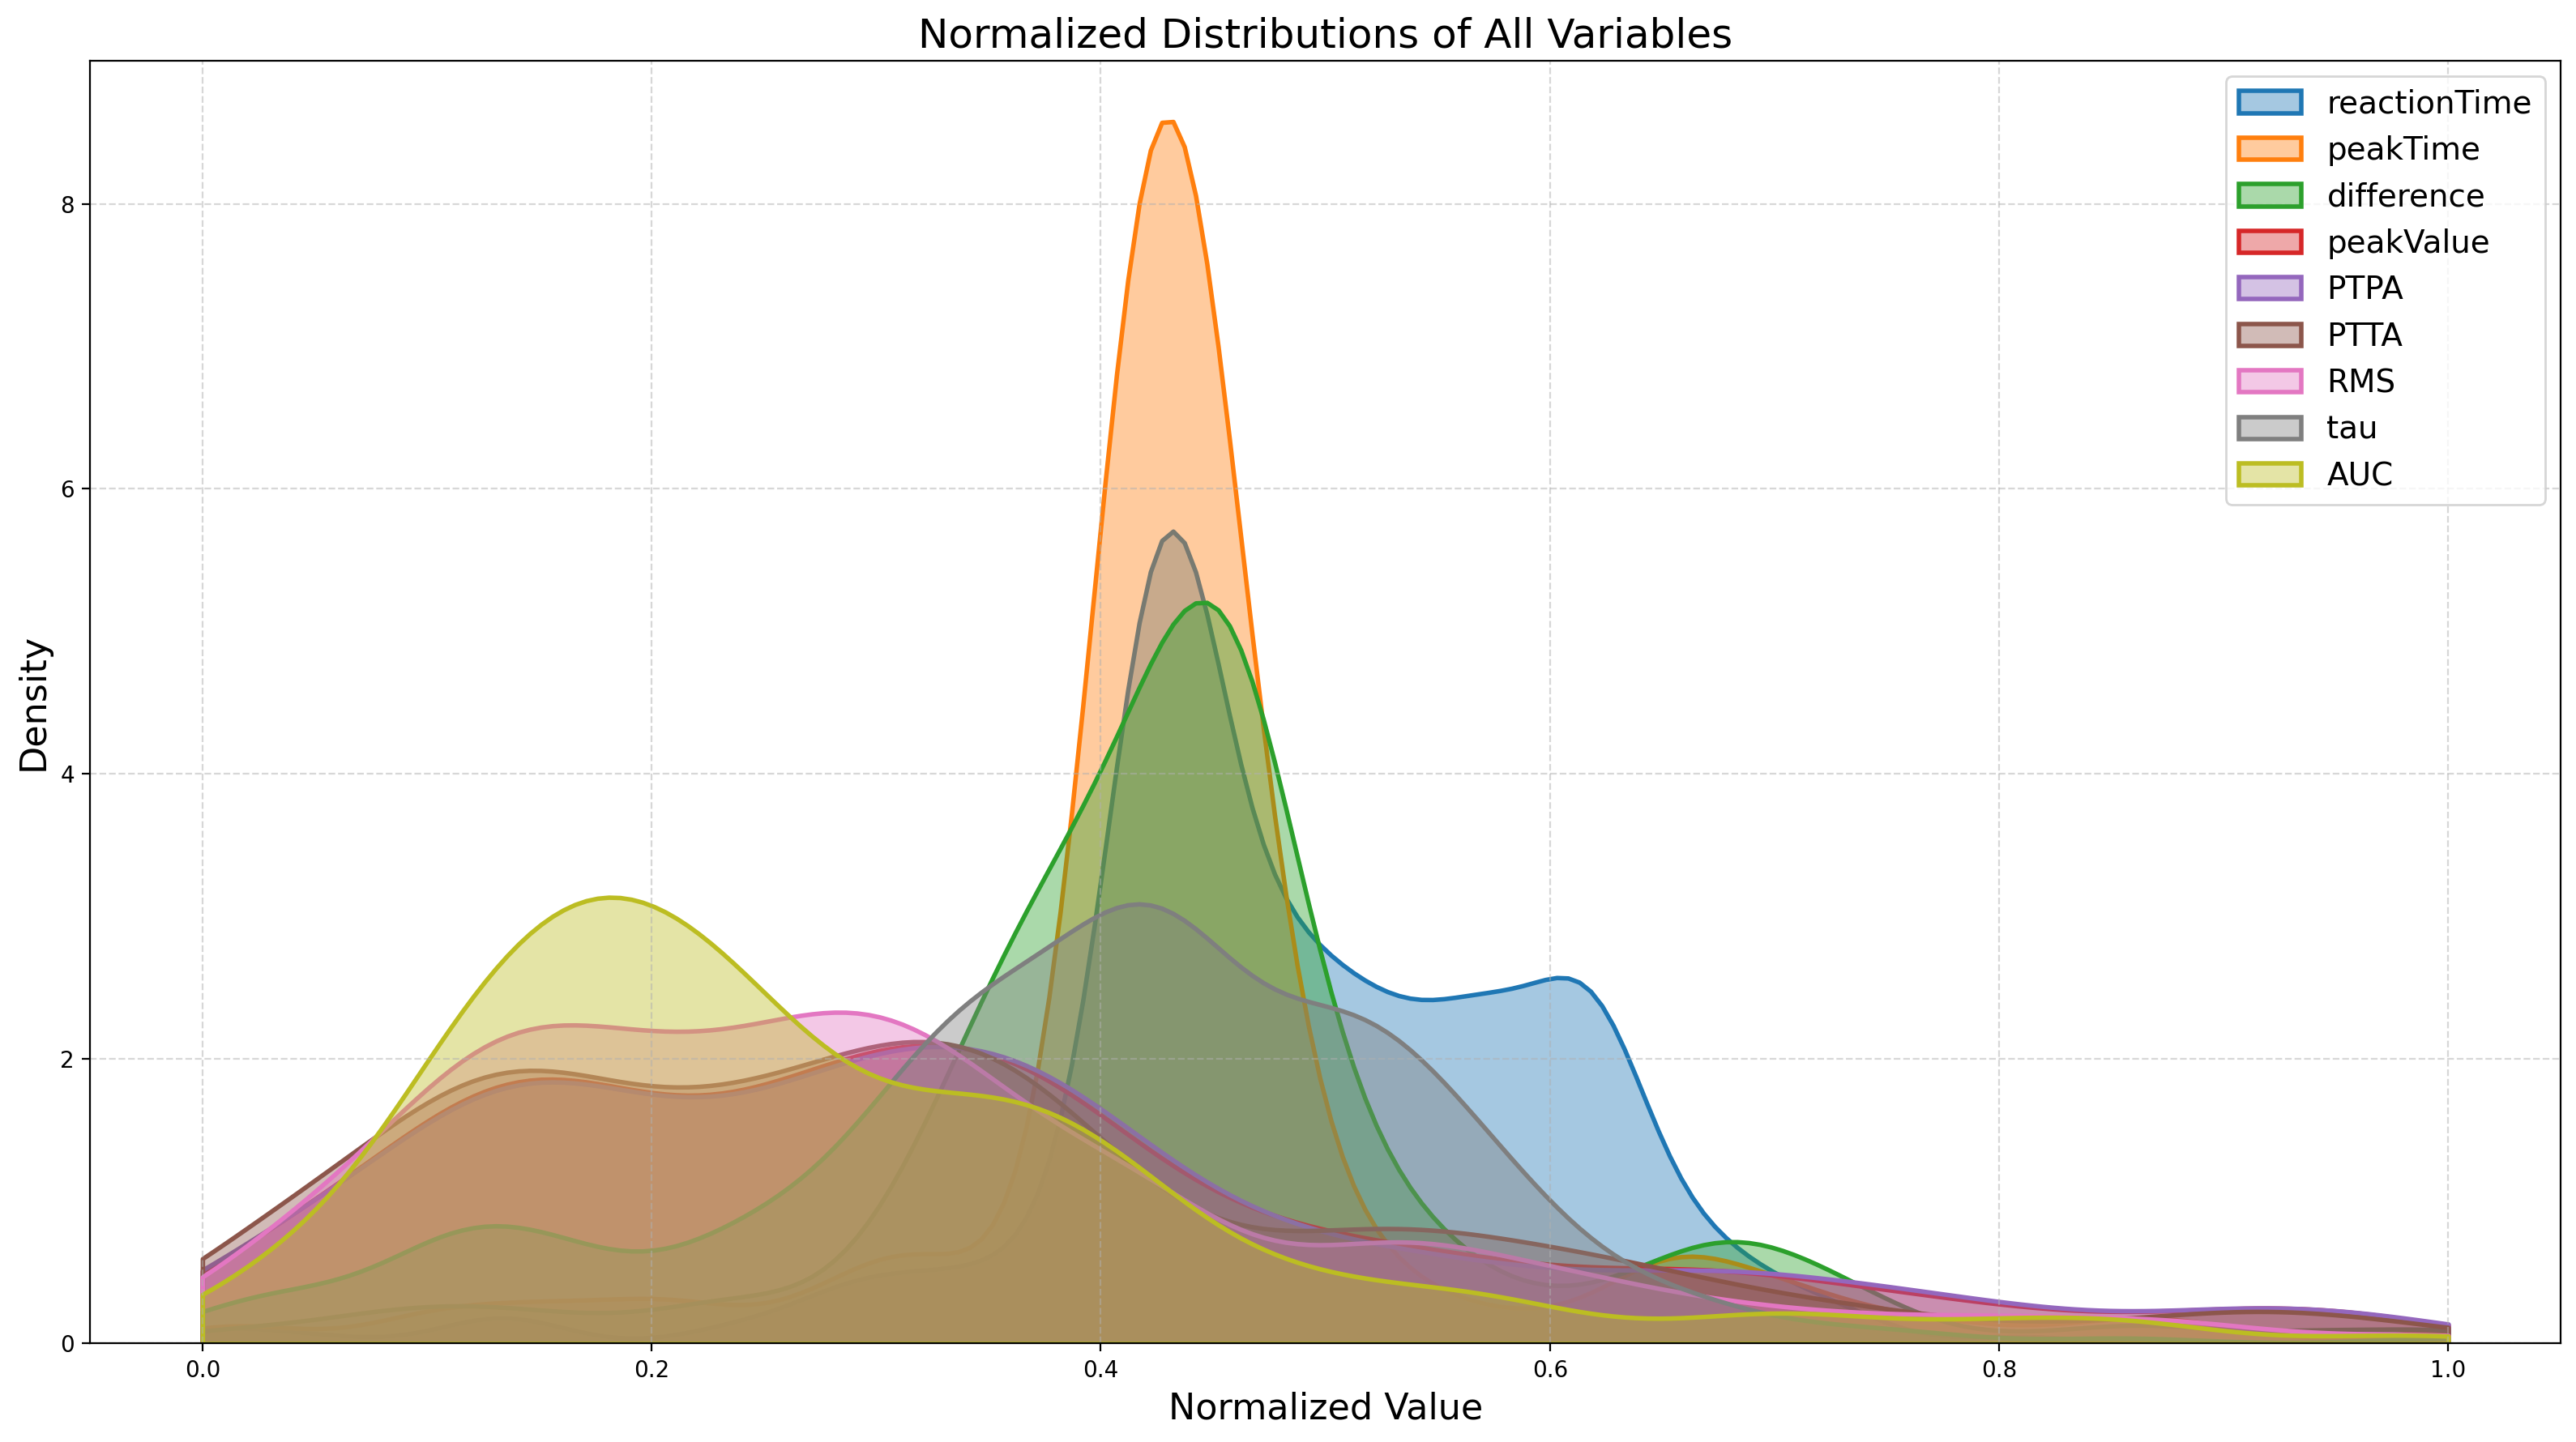

In [8]:
# ...existing code...

import matplotlib.pyplot as plt
import seaborn as sns

df = dfs['RESULTS_MTT_MERGED']
variables = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

plt.figure(figsize=(16, 9), dpi=200)
for var in variables:
    vals = pd.to_numeric(df[var], errors='coerce').dropna()
    norm_vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
    sns.kdeplot(
        norm_vals,
        label=var,
        fill=True,
        alpha=0.4,
        linewidth=2,
        bw_adjust=0.7,
        clip=(0, 1)
    )
plt.xlabel("Normalized Value", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Normalized Distributions of All Variables", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ...existing code...

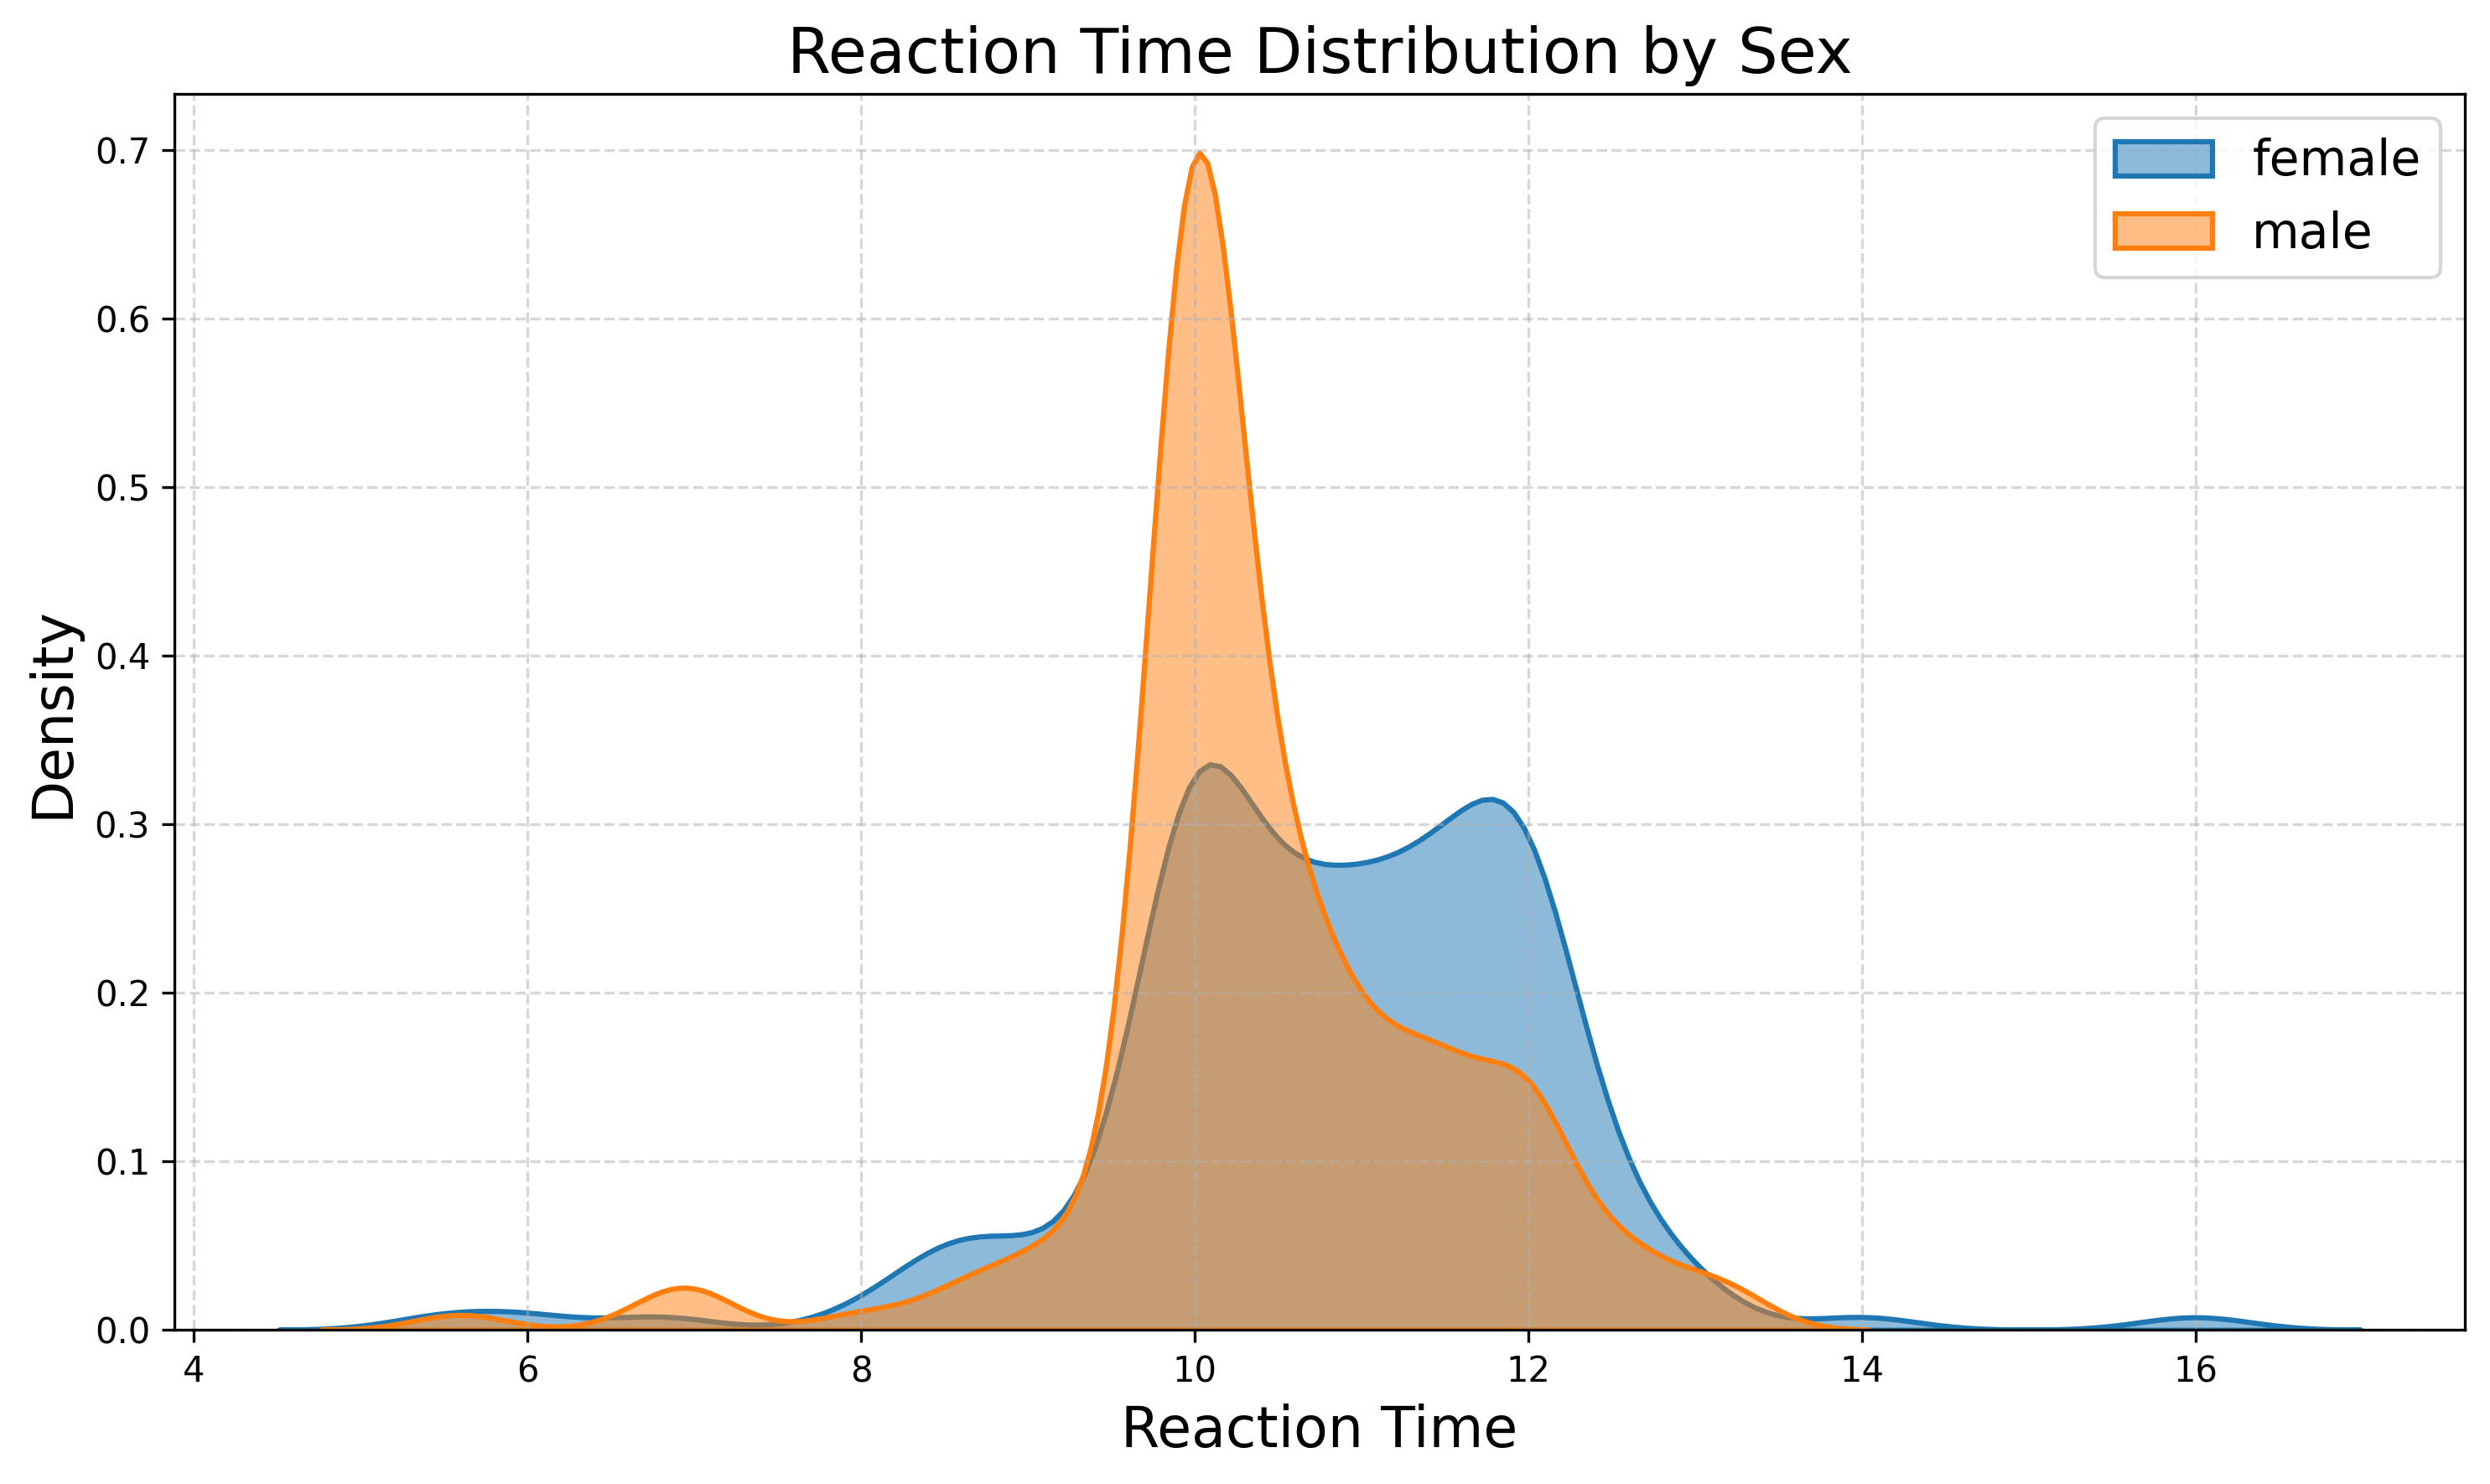

In [9]:
# ...existing code...

import matplotlib.pyplot as plt
import seaborn as sns

df = dfs['RESULTS_MTT_MERGED']

plt.figure(figsize=(10, 6), dpi=300)  # High quality output

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    sns.kdeplot(
        vals,
        label=f"{sex}",
        fill=True,
        alpha=0.5,
        linewidth=1.5,
        bw_adjust=0.7
    )

plt.xlabel("Reaction Time", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Reaction Time Distribution by Sex", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ...existing code...



In [10]:
from scipy.stats import shapiro, gamma, weibull_min, boxcox, lognorm, t, yeojohnson
import numpy as np
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

df = dfs['RESULTS_MTT_MERGED']
variables = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

def try_transformations(vals):
    results = {}
    # Original
    results['original'] = shapiro(vals)[1] if len(vals) > 2 else np.nan
    # Gamma
    if len(vals) > 2 and (vals > 0).all():
        params = gamma.fit(vals, floc=0)
        trans = gamma.cdf(vals, *params)
        results['gamma'] = shapiro(trans)[1]
    # Weibull
    if len(vals) > 2 and (vals > 0).all():
        params = weibull_min.fit(vals, floc=0)
        trans = weibull_min.cdf(vals, *params)
        results['weibull'] = shapiro(trans)[1]
    # Box-Cox
    if len(vals) > 2 and (vals > 0).all():
        trans, _ = boxcox(vals)
        results['boxcox'] = shapiro(trans)[1]
    # Lognormal
    if len(vals) > 2 and (vals > 0).all():
        params = lognorm.fit(vals, floc=0)
        trans = lognorm.cdf(vals, *params)
        results['lognorm'] = shapiro(trans)[1]
    # Student-t
    if len(vals) > 2:
        params = t.fit(vals)
        trans = t.cdf(vals, *params)
        results['student_t'] = shapiro(trans)[1]
    # Yeo-Johnson
    if len(vals) > 2:
        trans, _ = yeojohnson(vals)
        results['yeojohnson'] = shapiro(trans)[1]
    # Log
    if len(vals) > 2 and (vals > 0).all():
        trans = np.log(vals + 1e-6)
        results['log'] = shapiro(trans)[1]
    # Sqrt
    if len(vals) > 2 and (vals >= 0).all():
        trans = np.sqrt(vals)
        results['sqrt'] = shapiro(trans)[1]
    # Z-score
    if len(vals) > 2:
        trans = (vals - vals.mean()) / (vals.std() + 1e-8)
        results['zscore'] = shapiro(trans)[1]
    # Min-max
    if len(vals) > 2:
        trans = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
        results['minmax'] = shapiro(trans)[1]
    # Quantile (normal)
    if len(vals) > 2:
        qt = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=min(len(vals), 1000))
        trans = qt.fit_transform(vals.values.reshape(-1, 1)).flatten()
        results['quantile'] = shapiro(trans)[1]
    # Power (Yeo-Johnson, sklearn)
    if len(vals) > 2:
        pt = PowerTransformer(method='yeo-johnson')
        trans = pt.fit_transform(vals.values.reshape(-1, 1)).flatten()
        results['power'] = shapiro(trans)[1]
    return results

for sex in df['sex'].unique():
    for date in df['date'].unique():
        print(f"\nSex: {sex}, Date: {date}")
        for var in variables:
            vals = pd.to_numeric(df[(df['sex'] == sex) & (df['date'] == date)][var], errors='coerce').dropna()
            res = try_transformations(vals)
            for method, p in res.items():
                print(f"{var:15} {method:10}: p={p:.3e} {'normal' if p > 0.05 else 'NOT normal'}")


Sex: female, Date: April16
reactionTime    original  : p=1.282e-01 normal
reactionTime    gamma     : p=7.253e-04 NOT normal
reactionTime    weibull   : p=1.048e-03 NOT normal
reactionTime    boxcox    : p=1.295e-01 normal
reactionTime    lognorm   : p=7.195e-04 NOT normal
reactionTime    student_t : p=7.293e-04 NOT normal
reactionTime    yeojohnson: p=1.295e-01 normal
reactionTime    log       : p=1.071e-01 normal
reactionTime    sqrt      : p=1.206e-01 normal
reactionTime    zscore    : p=1.282e-01 normal
reactionTime    minmax    : p=1.282e-01 normal
reactionTime    quantile  : p=3.633e-05 NOT normal
reactionTime    power     : p=1.295e-01 normal
peakTime        original  : p=2.695e-08 NOT normal
peakTime        gamma     : p=2.932e-05 NOT normal
peakTime        weibull   : p=2.343e-05 NOT normal
peakTime        boxcox    : p=1.174e-07 NOT normal
peakTime        lognorm   : p=2.987e-05 NOT normal
peakTime        student_t : p=2.845e-05 NOT normal
peakTime        yeojohnson: p=1.171

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


peakTime        original  : p=2.966e-11 NOT normal
peakTime        gamma     : p=4.241e-09 NOT normal
peakTime        weibull   : p=2.280e-10 NOT normal
peakTime        boxcox    : p=1.000e+00 normal
peakTime        lognorm   : p=5.312e-09 NOT normal
peakTime        student_t : p=2.608e-09 NOT normal
peakTime        yeojohnson: p=2.028e-08 NOT normal
peakTime        log       : p=5.778e-11 NOT normal
peakTime        sqrt      : p=4.134e-11 NOT normal
peakTime        zscore    : p=2.966e-11 NOT normal
peakTime        minmax    : p=2.966e-11 NOT normal
peakTime        quantile  : p=6.788e-08 NOT normal
peakTime        power     : p=2.028e-08 NOT normal
difference      original  : p=9.115e-08 NOT normal
difference      gamma     : p=1.258e-03 NOT normal
difference      weibull   : p=4.407e-05 NOT normal
difference      boxcox    : p=3.335e-02 NOT normal
difference      lognorm   : p=1.929e-03 NOT normal
difference      student_t : p=3.432e-03 NOT normal
difference      yeojohnson: p=3.381

### ---> Box-Cox could work, especially for strength metrics which are already closer to normality by default

In [11]:
from scipy.stats import boxcox, shapiro
import numpy as np

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

print("\nBox-Cox normality results (split by sex and date):")
for sex in df['sex'].unique():
    for date in df['date'].unique():
        print(f"\nSex: {sex}, Date: {date}")
        for metric in metrics:
            vals = pd.to_numeric(df[(df['sex'] == sex) & (df['date'] == date)][metric], errors='coerce').dropna()
            # Box-Cox requires all values > 0 and at least 3 samples
            if len(vals) > 2 and (vals > 0).all():
                transformed, _ = boxcox(vals)
                stat, p = shapiro(transformed)
                print(f"{metric:15}: p={p:.3e} {'normal' if p > 0.05 else 'NOT normal'}")
            else:
                print(f"{metric:15}: Not enough data or non-positive values")


Box-Cox normality results (split by sex and date):

Sex: female, Date: April16
reactionTime   : p=1.295e-01 normal
peakTime       : p=1.174e-07 NOT normal
difference     : p=4.846e-02 NOT normal
peakValue      : p=1.140e-01 normal
PTPA           : p=1.205e-01 normal
PTTA           : p=1.060e-01 normal
RMS            : p=1.291e-01 normal
tau            : p=4.176e-01 normal
AUC            : p=1.750e-01 normal

Sex: female, Date: June26
reactionTime   : p=1.492e-02 NOT normal
peakTime       : p=5.469e-09 NOT normal
difference     : p=4.233e-02 NOT normal
peakValue      : p=5.517e-02 normal
PTPA           : p=3.275e-02 NOT normal
PTTA           : p=9.054e-02 normal
RMS            : p=9.945e-02 normal
tau            : p=1.997e-01 normal
AUC            : p=4.594e-02 NOT normal

Sex: female, Date: May20
reactionTime   : p=7.507e-04 NOT normal
peakTime       : p=1.000e+00 normal
difference     : p=3.335e-02 NOT normal
peakValue      : p=1.809e-02 NOT normal
PTPA           : p=1.937e-02 NOT no

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


### ---> not great, use non-parametric tests instead

---

## Uniformity

In [12]:
from scipy.stats import kstest

metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]
for sex in df['sex'].unique():
    for date in df['date'].unique():
        print(f"\nSex: {sex}, Date: {date}")
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for metric in metrics:
            vals = pd.to_numeric(df_sub[metric], errors='coerce').dropna()
            if len(vals) > 2:
                stat, p = kstest(vals, 'uniform', args=(vals.min(), vals.max() - vals.min()))
                print(f"{metric}: KS stat={stat:.3f}, p={p:.3e} {'uniform' if p > 0.05 else 'NOT uniform'}")
            else:
                print(f"{metric}: Not enough data")


Sex: female, Date: April16
reactionTime: KS stat=0.211, p=1.369e-02 NOT uniform
peakTime: KS stat=0.508, p=1.828e-13 NOT uniform
difference: KS stat=0.326, p=1.313e-05 NOT uniform
peakValue: KS stat=0.141, p=2.108e-01 uniform
PTPA: KS stat=0.149, p=1.635e-01 uniform
PTTA: KS stat=0.091, p=7.262e-01 uniform
RMS: KS stat=0.167, p=8.684e-02 uniform
tau: KS stat=0.283, p=2.601e-04 NOT uniform
AUC: KS stat=0.178, p=5.659e-02 uniform

Sex: female, Date: June26
reactionTime: KS stat=0.395, p=4.165e-08 NOT uniform
peakTime: KS stat=0.534, p=6.100e-15 NOT uniform
difference: KS stat=0.396, p=3.686e-08 NOT uniform
peakValue: KS stat=0.189, p=3.725e-02 NOT uniform
PTPA: KS stat=0.185, p=4.331e-02 NOT uniform
PTTA: KS stat=0.171, p=7.384e-02 uniform
RMS: KS stat=0.105, p=5.501e-01 uniform
tau: KS stat=0.291, p=1.483e-04 NOT uniform
AUC: KS stat=0.087, p=7.813e-01 uniform

Sex: female, Date: May20
reactionTime: KS stat=0.326, p=1.313e-05 NOT uniform
peakTime: KS stat=0.642, p=3.626e-22 NOT uniform

### ---> not too uniform

In [13]:
from scipy.stats import gamma, weibull_min, boxcox, lognorm, t, kstest, yeojohnson
import numpy as np
import pandas as pd

try:
    from sklearn.preprocessing import QuantileTransformer, PowerTransformer
    sklearn_available = True
except ImportError:
    sklearn_available = False

df = dfs['RESULTS_MTT_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]

def test_uniformity_grouped(transform_func, df, metrics, label):
    print(f"\n{label} transformation (grouped by sex and date):")
    for sex in df['sex'].unique():
        for date in df['date'].unique():
            df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
            if len(df_sub) < 3:
                continue
            transformed = transform_func(df_sub, metrics)
            print(f"\nSex: {sex}, Date: {date}")
            for metric in metrics:
                vals = pd.to_numeric(transformed[metric], errors='coerce').dropna()
                if len(vals) > 2:
                    stat, p = kstest(vals, 'uniform', args=(vals.min(), vals.max() - vals.min()))
                    print(f"{metric}: KS stat={stat:.3f}, p={p:.3e} {'uniform' if p > 0.05 else 'NOT uniform'}")
                else:
                    print(f"{metric}: Not enough data")

def gamma_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna()
        if len(vals) > 2 and (vals > 0).all():
            params = gamma.fit(vals, floc=0)
            df_copy[metric] = gamma.cdf(pd.to_numeric(df_copy[metric], errors='coerce'), *params)
        else:
            df_copy[metric] = np.nan
    return df_copy

def weibull_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna() + 1e-6
        if len(vals) > 2 and (vals > 0).all():
            params = weibull_min.fit(vals, floc=0)
            df_copy[metric] = weibull_min.cdf(pd.to_numeric(df_copy[metric], errors='coerce') + 1e-6, *params)
        else:
            df_copy[metric] = np.nan
    return df_copy

def boxcox_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna() + 1e-6
        if len(vals) > 2 and (vals > 0).all():
            transformed, _ = boxcox(vals)
            df_copy.loc[vals.index, metric] = transformed
        else:
            df_copy[metric] = np.nan
    return df_copy

def lognorm_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna() + 1e-6
        if len(vals) > 2 and (vals > 0).all():
            params = lognorm.fit(vals, floc=0)
            df_copy[metric] = lognorm.cdf(pd.to_numeric(df_copy[metric], errors='coerce') + 1e-6, *params)
        else:
            df_copy[metric] = np.nan
    return df_copy

def student_t_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna() + 1e-6
        if len(vals) > 2:
            params = t.fit(vals)
            df_copy[metric] = t.cdf(pd.to_numeric(df_copy[metric], errors='coerce') + 1e-6, *params)
        else:
            df_copy[metric] = np.nan
    return df_copy

def yeojohnson_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna()
        if len(vals) > 2:
            transformed, _ = yeojohnson(vals)
            df_copy.loc[vals.index, metric] = transformed
        else:
            df_copy[metric] = np.nan
    return df_copy

def log_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna()
        if len(vals) > 2 and (vals > 0).all():
            df_copy.loc[vals.index, metric] = np.log(vals + 1e-6)
        else:
            df_copy[metric] = np.nan
    return df_copy

def sqrt_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna()
        if len(vals) > 2 and (vals >= 0).all():
            df_copy.loc[vals.index, metric] = np.sqrt(vals)
        else:
            df_copy[metric] = np.nan
    return df_copy

def zscore_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna()
        if len(vals) > 2:
            df_copy.loc[vals.index, metric] = (vals - vals.mean()) / (vals.std() + 1e-8)
        else:
            df_copy[metric] = np.nan
    return df_copy

def minmax_transform(df, metrics):
    df_copy = df.copy()
    for metric in metrics:
        vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna()
        if len(vals) > 2:
            df_copy.loc[vals.index, metric] = (vals - vals.min()) / (vals.max() - vals.min() + 1e-8)
        else:
            df_copy[metric] = np.nan
    return df_copy

if sklearn_available:
    def quantile_transform(df, metrics):
        df_copy = df.copy()
        qt = QuantileTransformer(output_distribution='uniform', random_state=0)
        for metric in metrics:
            vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna().values.reshape(-1, 1)
            if len(vals) > 2:
                transformed = qt.fit_transform(vals).flatten()
                df_copy.loc[df_copy[metric].dropna().index, metric] = transformed
            else:
                df_copy[metric] = np.nan
        return df_copy

    def power_transform(df, metrics):
        df_copy = df.copy()
        pt = PowerTransformer(method='yeo-johnson')
        for metric in metrics:
            vals = pd.to_numeric(df_copy[metric], errors='coerce').dropna().values.reshape(-1, 1)
            if len(vals) > 2:
                transformed = pt.fit_transform(vals).flatten()
                df_copy.loc[df_copy[metric].dropna().index, metric] = transformed
            else:
                df_copy[metric] = np.nan
        return df_copy

# Run all transformations grouped by sex and date
test_uniformity_grouped(gamma_transform, df, metrics, "Gamma")
test_uniformity_grouped(weibull_transform, df, metrics, "Weibull")
test_uniformity_grouped(boxcox_transform, df, metrics, "Box-Cox")
test_uniformity_grouped(lognorm_transform, df, metrics, "Lognormal")
test_uniformity_grouped(student_t_transform, df, metrics, "Student-t")
test_uniformity_grouped(yeojohnson_transform, df, metrics, "Yeo-Johnson")
test_uniformity_grouped(log_transform, df, metrics, "Log")
test_uniformity_grouped(sqrt_transform, df, metrics, "Sqrt")
test_uniformity_grouped(zscore_transform, df, metrics, "Z-score")
test_uniformity_grouped(minmax_transform, df, metrics, "Min-max")

if sklearn_available:
    test_uniformity_grouped(quantile_transform, df, metrics, "Quantile (uniform)")
    test_uniformity_grouped(power_transform, df, metrics, "Power (Yeo-Johnson, sklearn)")
else:
    print("\nscikit-learn not available: skipping quantile and power transforms.")


Gamma transformation (grouped by sex and date):

Sex: female, Date: April16
reactionTime: KS stat=0.173, p=6.970e-02 uniform
peakTime: KS stat=0.291, p=1.472e-04 NOT uniform
difference: KS stat=0.140, p=2.185e-01 uniform
peakValue: KS stat=0.128, p=3.088e-01 uniform
PTPA: KS stat=0.125, p=3.357e-01 uniform
PTTA: KS stat=0.135, p=2.527e-01 uniform
RMS: KS stat=0.175, p=6.459e-02 uniform
tau: KS stat=0.146, p=1.798e-01 uniform
AUC: KS stat=0.169, p=8.006e-02 uniform

Sex: female, Date: June26
reactionTime: KS stat=0.265, p=7.927e-04 NOT uniform
peakTime: KS stat=0.408, p=1.199e-08 NOT uniform
difference: KS stat=0.224, p=7.334e-03 NOT uniform
peakValue: KS stat=0.177, p=5.857e-02 uniform
PTPA: KS stat=0.195, p=2.860e-02 NOT uniform
PTTA: KS stat=0.163, p=1.023e-01 uniform
RMS: KS stat=0.153, p=1.452e-01 uniform
tau: KS stat=0.157, p=1.235e-01 uniform
AUC: KS stat=0.131, p=2.894e-01 uniform

Sex: female, Date: May20
reactionTime: KS stat=0.170, p=7.926e-02 uniform
peakTime: KS stat=0.450

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2148: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)



peakTime: KS stat=0.349, p=2.172e-06 NOT uniform
difference: KS stat=0.330, p=9.455e-06 NOT uniform
peakValue: KS stat=0.114, p=4.565e-01 uniform
PTPA: KS stat=0.178, p=5.624e-02 uniform
PTTA: KS stat=0.205, p=1.791e-02 NOT uniform
RMS: KS stat=0.133, p=2.741e-01 uniform
tau: KS stat=0.183, p=4.662e-02 NOT uniform
AUC: KS stat=0.115, p=4.402e-01 uniform

Sex: male, Date: June26
reactionTime: KS stat=0.493, p=1.260e-12 NOT uniform
peakTime: KS stat=0.233, p=4.691e-03 NOT uniform
difference: KS stat=0.231, p=5.248e-03 NOT uniform
peakValue: KS stat=0.198, p=2.530e-02 NOT uniform
PTPA: KS stat=0.202, p=2.079e-02 NOT uniform
PTTA: KS stat=0.170, p=7.709e-02 uniform
RMS: KS stat=0.147, p=1.757e-01 uniform
tau: KS stat=0.087, p=7.782e-01 uniform
AUC: KS stat=0.093, p=7.032e-01 uniform

Sex: male, Date: May20
reactionTime: KS stat=0.341, p=4.025e-06 NOT uniform
peakTime: KS stat=0.415, p=6.089e-09 NOT uniform
difference: KS stat=0.321, p=1.941e-05 NOT uniform
peakValue: KS stat=0.083, p=8.19

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (54). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (54). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (54). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (54). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Galahad\AppData

AUC: KS stat=0.149, p=1.626e-01 uniform

Sex: female, Date: June26
reactionTime: KS stat=0.241, p=2.979e-03 NOT uniform
peakTime: KS stat=0.523, p=2.771e-14 NOT uniform
difference: KS stat=0.273, p=4.714e-04 NOT uniform
peakValue: KS stat=0.129, p=2.993e-01 uniform
PTPA: KS stat=0.122, p=3.667e-01 uniform
PTTA: KS stat=0.133, p=2.711e-01 uniform
RMS: KS stat=0.096, p=6.714e-01 uniform
tau: KS stat=0.150, p=1.601e-01 uniform
AUC: KS stat=0.087, p=7.788e-01 uniform

Sex: female, Date: May20
reactionTime: KS stat=0.305, p=5.922e-05 NOT uniform
peakTime: KS stat=0.405, p=1.556e-08 NOT uniform
difference: KS stat=0.289, p=1.734e-04 NOT uniform
peakValue: KS stat=0.100, p=6.217e-01 uniform
PTPA: KS stat=0.095, p=6.813e-01 uniform
PTTA: KS stat=0.092, p=7.209e-01 uniform
RMS: KS stat=0.101, p=6.011e-01 uniform
tau: KS stat=0.148, p=1.683e-01 uniform
AUC: KS stat=0.114, p=4.475e-01 uniform

Sex: male, Date: April16
reactionTime: KS stat=0.335, p=6.795e-06 NOT uniform
peakTime: KS stat=0.349, p

| Variable        | Most Suitable Fit/Transformation | Generally Good? | Notes                                                      |
|-----------------|----------------------------------|-----------------|------------------------------------------------------------|
| peakValue       | Quantile (uniform)               | Yes             | Consistently uniform for all sex/date groups               |
| RMS             | Quantile (uniform)               | Yes             | Consistently uniform for all sex/date groups               |
| tau             | Quantile (uniform)               | Yes             | Consistently uniform for all sex/date groups               |
| AUC             | Quantile (uniform)               | Yes             | Consistently uniform for all sex/date groups               |
| reactionTime    | Quantile (uniform)               | No              | Sometimes uniform, but not consistent across all groups    |
| peakTime        | No good fit                      | No              | No transformation yields uniformity                        |
| difference      | Quantile (uniform)               | No              | Sometimes uniform, but not consistent across all groups    |

**Notes:**  
- For strength metrics (peakValue, RMS, tau, AUC), Quantile (uniform) transformation is robust and generally good.
- For reaction metrics (reactionTime, peakTime, difference), no transformation is consistently good; Quantile (uniform) is the best available for reactionTime and difference, but not reliable.
- PeakTime cannot be made uniform with any tested transformation.

### ---> use quantile

The Quantile (uniform) transformation maps each value in a variable to its rank in the sorted data, then rescales these ranks to a uniform distribution between 0 and 1. This is done using the empirical cumulative distribution function (ECDF), so the transformed data is evenly spread regardless of the original distribution.

**Effect on analysis:**
- Makes variables comparable by removing distributional differences.
- Improves robustness for non-parametric statistics and tests that assume uniformity.
- Destroys the original scale and spacing, so only rank order is preserved.
- May obscure biological or experimental meaning if absolute values are important.

Use quantile transformation when you need standardized, comparable variables and distributional assumptions are problematic, but be cautious if the original scale matters for interpretation.

In [14]:
# Suppress sklearn QuantileTransformer warning by setting n_quantiles to min(n_samples, 1000)
from sklearn.preprocessing import QuantileTransformer

def quantile_fit_df(df):
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        vals = pd.to_numeric(df_copy[col], errors='coerce').dropna().values.reshape(-1, 1)
        n_samples = len(vals)
        if n_samples > 2:
            qt = QuantileTransformer(output_distribution='uniform', random_state=0, n_quantiles=min(n_samples, 1000))
            transformed = qt.fit_transform(vals).flatten()
            df_copy.loc[df_copy[col].dropna().index, col] = transformed
        else:
            df_copy[col] = np.nan
    return df_copy

fit_keys = list(dfs.keys())
for key in fit_keys:
    df = dfs[key]
    dfs[f"{key}_FIT"] = quantile_fit_df(df)

print(f"Applied quantile fit and saved {len(dfs)} dataframes with '_FIT' suffix.")

Applied quantile fit and saved 26 dataframes with '_FIT' suffix.


C:\Users\Galahad\AppData\Local\Temp\ipykernel_23572\3600028091.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00000000e+00 6.08272506e-04 1.21654501e-03 ... 9.98783455e-01
 9.99391727e-01 1.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.loc[df_copy[col].dropna().index, col] = transformed


In [15]:
from scipy.stats import kstest

metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date']]
for sex in df['sex'].unique():
    for date in df['date'].unique():
        print(f"\nSex: {sex}, Date: {date}")
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for metric in metrics:
            vals = pd.to_numeric(df_sub[metric], errors='coerce').dropna()
            if len(vals) > 2:
                stat, p = kstest(vals, 'uniform', args=(vals.min(), vals.max() - vals.min()))
                print(f"{metric}: KS stat={stat:.3f}, p={p:.3e} {'uniform' if p > 0.05 else 'NOT uniform'}")
            else:
                print(f"{metric}: Not enough data")


Sex: female, Date: April16
reactionTime: KS stat=0.348, p=7.370e-01 uniform
peakTime: KS stat=0.554, p=2.196e-01 uniform
difference: KS stat=0.333, p=7.778e-01 uniform
peakValue: KS stat=0.333, p=7.778e-01 uniform
PTPA: KS stat=0.333, p=7.778e-01 uniform
PTTA: KS stat=0.333, p=7.778e-01 uniform
RMS: KS stat=0.333, p=7.778e-01 uniform
tau: KS stat=0.610, p=1.298e-01 uniform
AUC: KS stat=0.514, p=3.021e-01 uniform

Sex: female, Date: June26
reactionTime: KS stat=0.333, p=7.778e-01 uniform
peakTime: KS stat=0.453, p=4.505e-01 uniform
difference: KS stat=0.333, p=7.778e-01 uniform
peakValue: KS stat=0.357, p=7.135e-01 uniform
PTPA: KS stat=0.362, p=7.007e-01 uniform
PTTA: KS stat=0.396, p=6.065e-01 uniform
RMS: KS stat=0.333, p=7.778e-01 uniform
tau: KS stat=0.333, p=7.778e-01 uniform
AUC: KS stat=0.333, p=7.778e-01 uniform

Sex: female, Date: May20
reactionTime: KS stat=0.550, p=2.266e-01 uniform
peakTime: KS stat=0.333, p=7.778e-01 uniform
difference: KS stat=0.333, p=7.778e-01 uniform


### ---> uniformity improved

---

In [16]:
import os

output_dir = "Analyzer Results"
os.makedirs(output_dir, exist_ok=True)

for key, df in dfs.items():
    output_path = os.path.join(output_dir, f"{key}.xlsx")
    df.to_excel(output_path, index=False)

print(f"Saved {len(dfs)} dataframes to '{output_dir}' as .xlsx files.")

Saved 26 dataframes to 'Analyzer Results' as .xlsx files.
